<a href="https://colab.research.google.com/github/Pouyan-np/MvTec_Padim-Model/blob/main/Mvtec_Padim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install anomalib
!anomalib install -v

In [2]:
from typing import Any

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer, ExportType
from anomalib.engine import Engine
from anomalib.models import Padim



**Dataset: MVTec AD**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path of the data
root_dir = '/content/drive/MyDrive/datasets/MVTec'

# Create data module and use it
datamodule = MVTec(root_dir, num_workers=0)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())


Mounted at /content/drive
dict_keys(['image_path', 'label', 'image', 'mask'])


**Let's check the shapes of the input images and masks.**

In [4]:
print(data["image"].shape, data["mask"].shape)


torch.Size([32, 3, 900, 900]) torch.Size([32, 900, 900])


**We could now visualize a normal and abnormal sample from the validation set.**



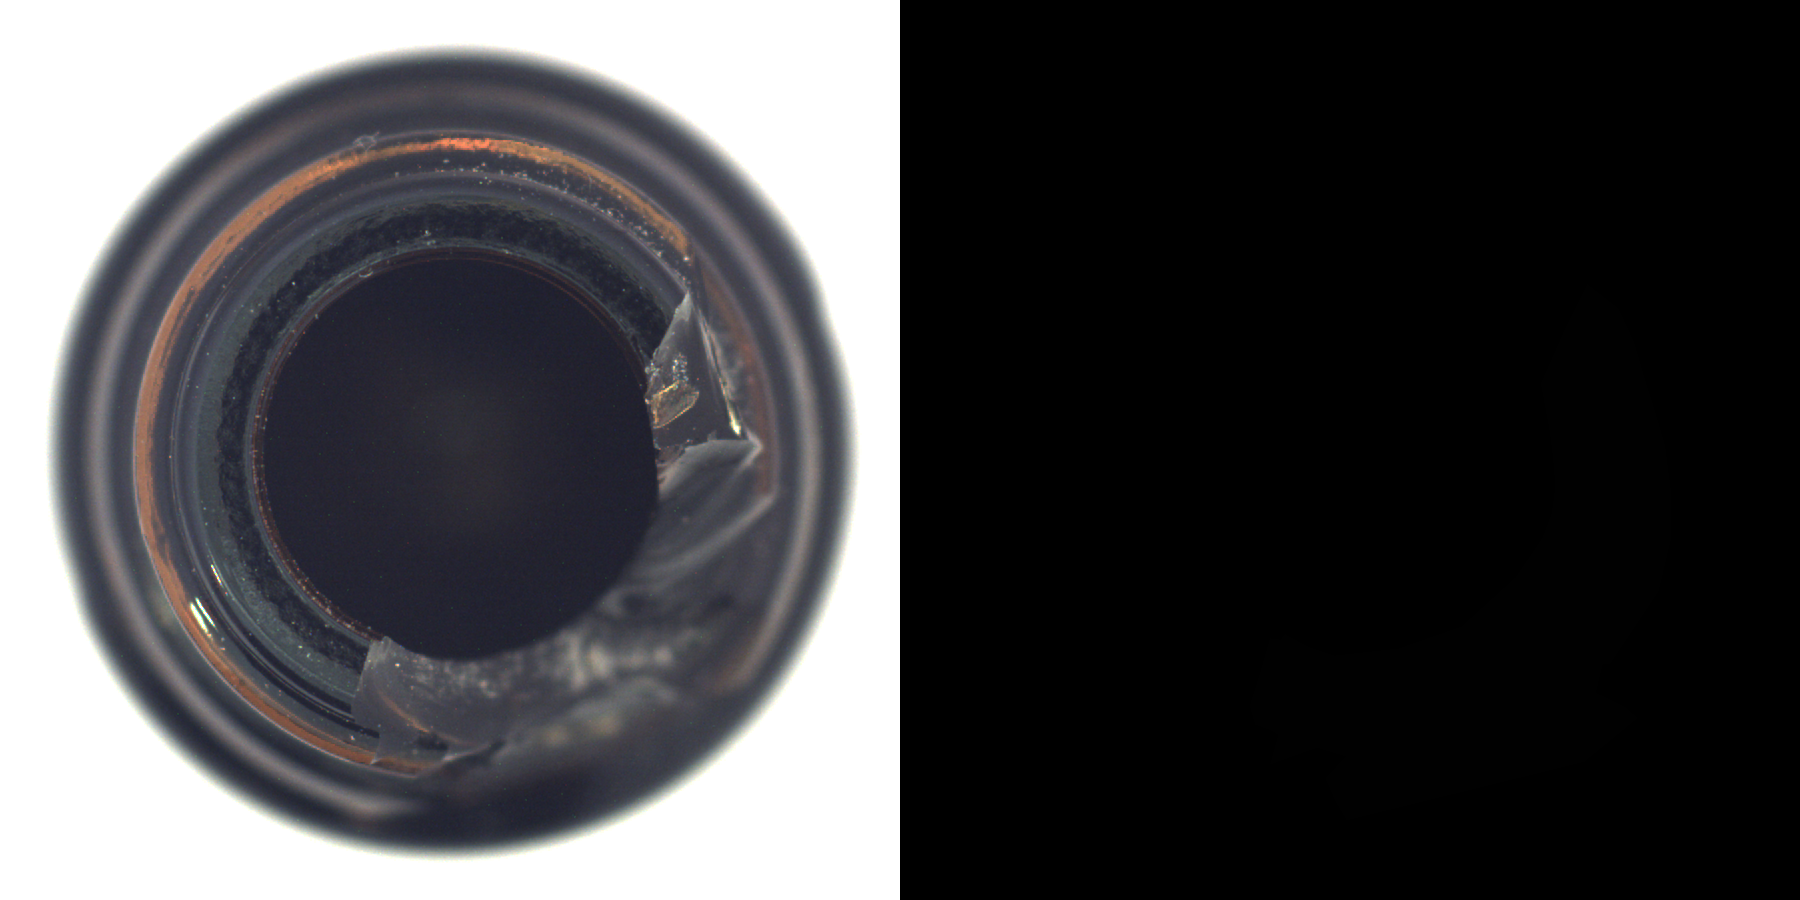

In [5]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """Show an image with a mask.

    Args:
        sample (dict[str, Any]): Sample from the dataset.
        index (int): Index of the sample.

    Returns:
        Image: Output image with a mask.
    """
    # Load the image from the path
    image = Image.open(sample["image_path"][index])

    # Load the mask and convert it to RGB
    mask = ToPILImage()(sample["mask"][index]).convert("RGB")

    # Resize mask to match image size, if they differ
    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

In [6]:
import os

# Define the root directory of your dataset
root_dir = '/content/drive/MyDrive/datasets/MVTec'

# Get list of categories (sub-directories) in the dataset
categories = os.listdir(root_dir)

# Print the list of categories
print("Available categories in the dataset:")
print(categories)



Available categories in the dataset:
['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper', 'readme.txt', 'license.txt']


In [7]:
# Define the root directory where your dataset is located
root_dir = '/content/drive/MyDrive/datasets/MVTec'



**Prepare Model**: Let's create the Padim and train it on the bottle category

In [8]:
# Get the model and datamodule
model = Padim()
datamodule_MvTec = MVTec(
    root=root_dir,
    category="bottle",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,  # Adjust task type as needed
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [9]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule_MvTec)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so va

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/optimization/automatic.py:132: `training_step` 
returned `None`. If this was on purpose, ignore this warning...

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


**Validation**

In [10]:
# load best model from checkpoint before evaluating
test_results_MvTec = engine.test(
    model=model,
    datamodule=datamodule_MvTec,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Padim/MVTec/bottle/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Padim/MVTec/bottle/v0/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Padim/MVTec/bottle/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Padim/MVTec/bottle/v0/weights/lightning/model.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9968254566192627     │
│       image_F1Score       │    0.9763779640197754     │
│        pixel_AUROC        │     0.983380913734436     │
│       pixel_F1Score       │    0.7259947061538696     │
└───────────────────────────┴───────────────────────────┘

**Prepare Model**: Let's create the Padim and train it on the cable category.

In [11]:
# Get the model and datamodule
model = Padim()
datamodule_cable = MVTec(
    root=root_dir,
    category="cable",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,  # Adjust task type as needed
)


In [12]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule_cable)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so va

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [13]:
# load best model from checkpoint before evaluating
test_results_cable = engine.test(
    model=model,
    datamodule=datamodule_MvTec,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Padim/MVTec/cable/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Padim/MVTec/cable/v0/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Padim/MVTec/cable/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Padim/MVTec/cable/v0/weights/lightning/model.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6142857074737549     │
│       image_F1Score       │    0.8630136847496033     │
│        pixel_AUROC        │    0.5639997720718384     │
│       pixel_F1Score       │    0.10743007808923721    │
└───────────────────────────┴───────────────────────────┘

**Prepare Model:** Let's create the Padim and train it on the capsule category.

In [14]:
# Get the model and datamodule
model = Padim()
datamodule_capsule = MVTec(
    root=root_dir,
    category="capsule",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,  # Adjust task type as needed
)


In [15]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule_capsule)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so va

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [16]:
# load best model from checkpoint before evaluating
test_results_capsule = engine.test(
    model=model,
    datamodule=datamodule_capsule,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Padim/MVTec/capsule/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Padim/MVTec/capsule/v0/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Padim/MVTec/capsule/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Padim/MVTec/capsule/v0/weights/lightning/model.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8927004337310791     │
│       image_F1Score       │    0.9506726264953613     │
│        pixel_AUROC        │    0.9841709136962891     │
│       pixel_F1Score       │    0.42070379853248596    │
└───────────────────────────┴───────────────────────────┘

**Prepare Model:** Let's create the Padim and train it on the carpet category.

In [17]:
# Get the model and datamodule
model = Padim()
datamodule_carpet = MVTec(
    root=root_dir,
    category="carpet",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,  # Adjust task type as needed
)


In [18]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule_carpet)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so va

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [19]:
# load best model from checkpoint before evaluating
test_results_carpet = engine.test(
    model=model,
    datamodule=datamodule_carpet,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Padim/MVTec/carpet/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Padim/MVTec/carpet/v0/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Padim/MVTec/carpet/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Padim/MVTec/carpet/v0/weights/lightning/model.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9827448129653931     │
│       image_F1Score       │    0.9534883499145508     │
│        pixel_AUROC        │    0.9880241751670837     │
│       pixel_F1Score       │    0.5543606877326965     │
└───────────────────────────┴───────────────────────────┘

**Prepare Model:** Let's create the Padim and train it on the hazelnut category.

In [22]:
# Get the model and datamodule
model = Padim()
# Initialize MVTec dataset with wood category
datamodule_hazelnut = MVTec(
    root=root_dir,
    category="hazelnut",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,  # Adjust task type as needed
)


In [23]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule_hazelnut)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so va

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [24]:
# load best model from checkpoint before evaluating
test_results_hazelnut = engine.test(
    model=model,
    datamodule=datamodule_hazelnut,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Padim/MVTec/hazelnut/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Padim/MVTec/hazelnut/v0/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Padim/MVTec/hazelnut/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Padim/MVTec/hazelnut/v0/weights/lightning/model.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.643750011920929     │
│       image_F1Score       │    0.8074533939361572     │
│        pixel_AUROC        │     0.965634286403656     │
│       pixel_F1Score       │    0.4422681927680969     │
└───────────────────────────┴───────────────────────────┘

**Prepare Model:** Let's create the Padim and train it on the metal nut category.

In [25]:
# Get the model and datamodule
model = Padim()
# Initialize MVTec dataset with wood category
datamodule_metal_nut = MVTec(
    root=root_dir,
    category="metal_nut",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,  # Adjust task type as needed
)


In [26]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule_metal_nut)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so va

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [27]:
# load best model from checkpoint before evaluating
test_results_metal_nut = engine.test(
    model=model,
    datamodule=datamodule_metal_nut,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Padim/MVTec/metal_nut/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Padim/MVTec/metal_nut/v0/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Padim/MVTec/metal_nut/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Padim/MVTec/metal_nut/v0/weights/lightning/model.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9604105353355408     │
│       image_F1Score       │    0.9528796076774597     │
│        pixel_AUROC        │    0.9597238898277283     │
│       pixel_F1Score       │    0.7044600248336792     │
└───────────────────────────┴───────────────────────────┘

**Prepare Model:** Let's create the Padim and train it on the pill category.

In [28]:
# Get the model and datamodule
model = Padim()
# Initialize MVTec dataset with wood category
datamodule_pill = MVTec(
    root=root_dir,
    category="pill",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,  # Adjust task type as needed
)


In [29]:
# start training
engine = Engine(task=TaskType.SEGMENTATION)
engine.fit(model=model, datamodule=datamodule_pill)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so va

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [30]:
# load best model from checkpoint before evaluating
test_results_pill = engine.test(
    model=model,
    datamodule=datamodule_pill,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Padim/MVTec/pill/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Padim/MVTec/pill/v0/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Padim/MVTec/pill/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Padim/MVTec/pill/v0/weights/lightning/model.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9225313663482666     │
│       image_F1Score       │    0.9547038078308105     │
│        pixel_AUROC        │    0.9524987936019897     │
│       pixel_F1Score       │    0.5057321786880493     │
└───────────────────────────┴───────────────────────────┘

In [31]:
print(test_results_metal_nut)
print(test_results_pill)
print(test_results_hazelnut)
print(test_results_carpet)
print(test_results_capsule)
print(test_results_cable)
print(test_results_MvTec)

[{'pixel_AUROC': 0.9597238898277283, 'pixel_F1Score': 0.7044600248336792, 'image_AUROC': 0.9604105353355408, 'image_F1Score': 0.9528796076774597}]
[{'pixel_AUROC': 0.9524987936019897, 'pixel_F1Score': 0.5057321786880493, 'image_AUROC': 0.9225313663482666, 'image_F1Score': 0.9547038078308105}]
[{'pixel_AUROC': 0.965634286403656, 'pixel_F1Score': 0.4422681927680969, 'image_AUROC': 0.643750011920929, 'image_F1Score': 0.8074533939361572}]
[{'pixel_AUROC': 0.9880241751670837, 'pixel_F1Score': 0.5543606877326965, 'image_AUROC': 0.9827448129653931, 'image_F1Score': 0.9534883499145508}]
[{'pixel_AUROC': 0.9841709136962891, 'pixel_F1Score': 0.42070379853248596, 'image_AUROC': 0.8927004337310791, 'image_F1Score': 0.9506726264953613}]
[{'pixel_AUROC': 0.5639997720718384, 'pixel_F1Score': 0.10743007808923721, 'image_AUROC': 0.6142857074737549, 'image_F1Score': 0.8630136847496033}]
[{'pixel_AUROC': 0.983380913734436, 'pixel_F1Score': 0.7259947061538696, 'image_AUROC': 0.9968254566192627, 'image_F1S